In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
import plotly.express as px
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords
import re
from scipy.spatial.distance import cdist
from geopy.distance import distance as geodist # avoid naming confusion
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

In this homework you'll be competing with each other in predicting Airbnb prices for New York City. Competition will be set up on Kaggle. Below you'll find all the instructions.

* The link to the competition is [here](https://www.kaggle.com/t/a8b378243f404dc78a6b306bd73543ca)
* If you do not have a Kaggle account (which is quite probable), you'll have to register. Please, use your real name. Then, join the competition (blue button `Join Competition`)
* You will find datasets under the tab `Data`. You can download both files (`hw2_train.csv` and `hw2_test.csv`) on your computer and then load into colab.
* This notebook will give you first glimpse on the dataset, explain the task and show you how to make predictions. Your main task is to get the most accurate predictions (the lowest RMSE) on the test dataset, using the tricks we've discussed in class: EDA, Feature Engineering, Different models 
* When you are done with the model, you can submit your predictions (instruction are at the of the notebook)
* You can make up to 5 submissins per day.
* The final deadline is **1/06/2020 23:59**. 
* To avoid dishonest submissions, we ask everyone to send the notebook with your final solution to `dataculture2020+hw2@gmail.com`. Any kind of cheating will result in 0 grade for both suspects.
* Your grade will depend on the final score (see tab `Leaderboard` on Kaggle). Those, who will get to the first 3 rows on the leaderboard, will get **extra** points for the hw.

|Score range | Grade|
|-----|-----|
|[191.1, infinity)| 0| 
| [190,191.1)| 4|
| [185, 190) | 5|
| [180, 185)| 6|
| [175, 180)| 7|
| [170, 175)| 8|
| [165, 170)| 9|
| [0, 165)| 10|



Extra points:
* First place: **+1.5**  (11.5 for the hw max)
* Second place: **+1**  (10 for the hw max)
* Third place: **+0.5** (10.5 for the hw max)




In [2]:
df = pd.read_csv('content/hw2_train.csv', index_col=0)
df

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
36323065,Lovely Home Away,273177557,Veronica,Queens,Jamaica,40.66806,-73.77658,Private room,200,1,0,NaN,NaN,1,168
6168663,Private bedroom in sunny apt,15743117,Alice,Manhattan,Harlem,40.81192,-73.95239,Private room,79,5,2,2015-10-07,0.04,1,0
19070571,1 BR in Manhattan - Spacious and Convenient,39601665,Jordan,Manhattan,East Harlem,40.80746,-73.94001,Private room,53,180,0,NaN,NaN,1,357
15178955,Large 1 bedroom-Private Bath in 2 bed apartment,50860659,James,Queens,Ridgewood,40.70703,-73.90907,Private room,80,7,5,2019-01-04,0.15,1,188
2496301,"Comfy, Roomy Bushwick 1-BR ~ Steps from L/M Train",4142684,Suzette,Brooklyn,Bushwick,40.69587,-73.90960,Entire home/apt,108,3,232,2019-07-06,3.62,1,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31102513,Sweet Spot! 2 rooms w/ PRIVATE ENTRANCE in BK!,8960308,Siji,Brooklyn,East Flatbush,40.64168,-73.95026,Private room,59,2,16,2019-07-06,4.49,1,13
21892834,Executive Museum 1 BR Elevator Best Location,61391963,Corporate Housing,Manhattan,Upper West Side,40.78383,-73.97529,Entire home/apt,133,30,8,2019-06-30,0.43,91,301
22409383,Park Slope 15 min to MANHATTAN SLEEPS 10 + INFANT,3532263,Alejandro,Brooklyn,Gowanus,40.67023,-73.99235,Entire home/apt,349,2,19,2019-06-21,1.03,4,363


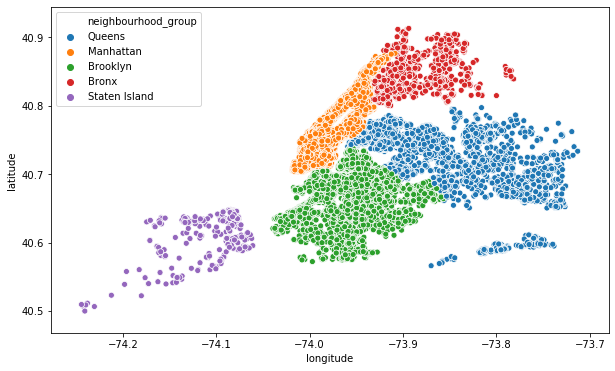

In [3]:
plt.figure(figsize=(10,6))
sns.scatterplot(df.longitude,df.latitude,hue=df.neighbourhood_group)
plt.ioff()

In [55]:
def Encode(df):
    df.fillna(0, inplace=True)
    df.drop(['name','host_name','last_review', 'host_id','latitude','longitude','neighbourhood','number_of_reviews','reviews_per_month'], axis=1, inplace=True)
    for column in df.columns[df.columns.isin(['neighbourhood_group', 'room_type'])]:
        df[column] = df[column].factorize()[0]
    return df

airbnb_en = Encode(df.copy())
airbnb_en.head()

,neighbourhood_group,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
id,,,,,,
36323065,0,0,200,1,1,168
6168663,1,0,79,5,1,0
19070571,1,0,53,180,1,357
15178955,0,0,80,7,1,188
2496301,2,1,108,3,1,89


Index(['neighbourhood_group', 'room_type', 'price', 'minimum_nights',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

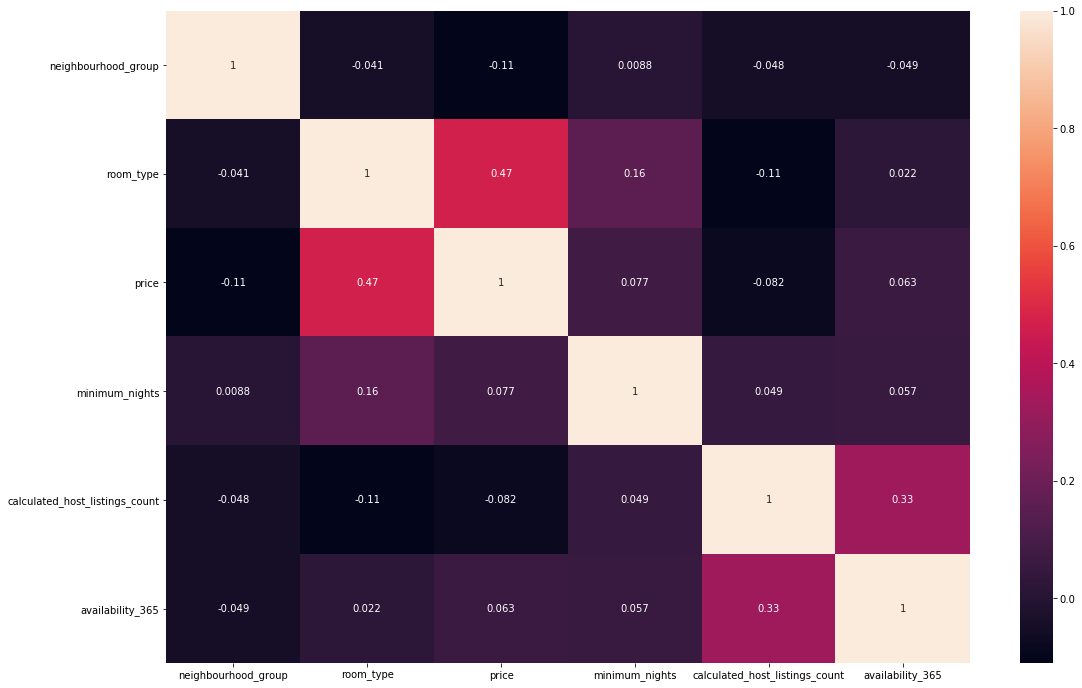

In [56]:
corr = airbnb_en.corr(method='kendall')
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True)
airbnb_en.columns

In [57]:
x = airbnb_en.drop(['price'], axis=1).values
y = airbnb_en['price'].values
#Getting Test and Training Set
scaler = StandardScaler()
x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.1,random_state=353)
x_train.shape

(33003, 5)

In [58]:
reg = XGBRegressor(n_estimators=30)
#reg = LinearRegression()
#reg = Lasso()
#reg = Ridge()
#reg = KNeighborsRegressor(5, metric='cosine')
#reg = DecisionTreeRegressor(min_samples_leaf=.0001)
params = {
    'max_depth': np.linspace(3, 7, 5, dtype=int),
    'learning_rate': np.logspace(1, 5, 5, base=0.6),
    'booster': ['gbtree', 'gblinear', 'dart'],
    
}

cv = KFold(4)

def rmse(y_pred, y_test):
    score = mean_squared_error(y_pred, y_test) ** 0.5
    return score
    
scorer = make_scorer(rmse, greater_is_better=False)
reg = GridSearchCV(XGBRegressor(n_estimators=30), params, scoring=scorer, cv=cv)

reg.fit(x, y)

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=Non...
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'learning_rate': array([0.6    , 0.36   , 0.216  , 0.1296 , 0.077

In [59]:
best_score = abs(reg.best_score_)
best_estimator = reg.best_estimator_
best_score

232.98393095976442

In [60]:
params = {
    'penalty': ['l2', 'l1'],
    'alpha': np.logspace(1, 4, 4, base=0.1),
    'tol': np.logspace(1, 4, 4, base=0.1),
    'epsilon': np.logspace(-1, 4, 6, base=0.1)
}

reg = GridSearchCV(SGDRegressor(), params, scoring=scorer, cv=cv)
reg.fit(x, y)

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0...
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.1   , 0.01  , 0.001 , 0.0001]),
                         'epsilon': array([1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04]),
          

In [61]:
if abs(reg.best_score_) < best_score:
    best_score = abs(reg.best_score_)
    best_estimator = reg.best_estimator_
best_score, best_estimator

(232.98393095976442,
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.21599999999999997, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None))

In [62]:
params = {
    'criterion': ['mse'],
    'max_depth': [5, 7, 9, 11],
    'min_samples_split': np.logspace(1, 4, 4, base=2, dtype=int)
}

reg = GridSearchCV(RandomForestRegressor(n_estimators=20), params, scoring=scorer, cv=cv)
reg.fit(x, y)

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=20, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             ver

In [63]:
if abs(reg.best_score_) < best_score:
    best_score = abs(reg.best_score_)
    best_estimator = reg.best_estimator_
best_score, best_estimator

(232.98393095976442,
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.21599999999999997, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None))

In [64]:
scores = []
for ind_tr, ind_test in cv.split(x):
    x_tr, x_test, y_tr, y_test = x[ind_tr], x[ind_test], y[ind_tr], y[ind_test]
    reg = LinearRegression()
    reg.fit(x_tr, y_tr)
    y_pred = reg.predict(x_test)
    sc = rmse(y_pred, y_test)
    scores.append(sc)
scores = np.array(scores).mean()
scores

243.99838771479972

In [65]:
if scores < best_score:
    best_score = scores
    best_estimator = LinearRegression()
best_score, best_estimator

(232.98393095976442,
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.21599999999999997, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None))

In [66]:
params = {
    'alpha': np.logspace(-1, 3, 5, base=0.1),
    'tol': np.logspace(-1, 4, 6, base=0.1)
}

reg = GridSearchCV(Ridge(), params, scoring=scorer, cv=cv)
reg.fit(x, y)

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03]),
                         'tol': array([1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(rmse, greater_is_better=False), verbose=0)

In [67]:
if abs(reg.best_score_) < best_score:
    best_score = abs(reg.best_score_)
    best_estimator = reg.best_estimator_
best_score, best_estimator

(232.98393095976442,
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.21599999999999997, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None))

In [68]:
best_estimator.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.21599999999999997, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=30, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [69]:
test_data = pd.read_csv('content/hw2_test.csv')

In [70]:
test_data = Encode(test_data)

In [71]:
test_data.head()

,id,neighbourhood_group,room_type,minimum_nights,calculated_host_listings_count,availability_365
0,14763255,0,0,1.0,1.0,28.0
1,28501387,1,1,4.0,3.0,0.0
2,13091309,1,1,30.0,87.0,328.0
3,4558046,0,1,7.0,1.0,0.0
4,21252149,1,0,1.0,1.0,197.0


In [72]:
X_test = scaler.transform(test_data.iloc[:, 1:].values)

In [73]:
pred = best_estimator.predict(X_test)

In [74]:
my_prediction = pd.DataFrame(data = pred, index=test_data.id, columns=['price'])
my_prediction.to_csv('content/my_submission4.csv')